# IRRmodel Water Content + Irrigation (model+run)

In [1]:
# Base
import os
import re
import time
import math
import numpy as np
import pandas as pd
import datetime as dtt

# Analysis
import pyswarms as ps
from scipy import special as sp
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from scipy.signal import savgol_filter as sfilter

# Geospatial
import fiona
import xarray as xr
import hydroeval as he
# import geopandas as gpd
# from maps_original import *

# Graphics
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyswarms.utils.plotters import plot_cost_history
from pyswarms.utils.functions.single_obj import sphere

# 6-parameters calibration model

In [2]:
def WPSO_6(PAR, inputs, user_in):
    """Irrigation model function for its calibration.
    
    Based on KGE minimization via PSO (pyswarm) optimization.
    Version with 6 parameters to calibrate.
    
    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
        PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc]
    - inputs = [D, P, IRR, EPOT, WWobs]
    
    Return
    -------
    KGE from hydroeval
    
    """

    # User input
    irri = user_in
    
    # Unpack inputs
    #PARs = convert_adim(PAR)
    W_0, W_max, S_fc, S_w, rho_st, Kc = PAR#s
    D, P, IRRobs, EPOT, Wobs = inputs
    
    #S_fc = 0.46 # hardcoded
    #S_w = 0.08  # hardcoded
    W_fc = S_fc*W_max # water content at field capacity
    W_w  = S_w*W_max # water content at wilting point
    
    if irri==True: IRR = [0]*len(D) # daily, water content
    else: IRR = IRRobs
    
    Ks = [0]*len(D) # daily, water stress coefficient
    rho = [0]*len(D) # daily, depletion fraction
    PS = [0]*len(D) # daily, deep percolation
    W = [0]*len(D) # daily, water content
    W[0] = W_0*W_max
    
    for t in [i+1 for i in range(len(D)-1)]:
        rho[t]=rho_st+0.04*(5-Kc*EPOT[t])
        if W[t-1]>=(1-rho[t])*W_fc:
            Ks[t]=1
        elif (W[t-1]>W_w)and(W[t-1]<(1-rho[t])*W_fc):
            Ks[t]=float(W[t-1]-W_w)/((1-rho[t])*(W_fc-W_w))
        else: Ks[t]=0
        
        DOY=D[t].dayofyear
        
        # Irrigation estimate (for summer season only)
        # Irrigation is estimated as the amount of water needed at the day before
        # to take water content up to field capacity
        if np.logical_and(DOY>134,DOY<235): # summer season
            if irri==True:
                if W[t-1]<=(1-rho[t])*W_fc: IRR[t]=W_fc-W[t-1]
        
        # Water balance
        W[t]=W[t-1]+P[t]+IRR[t]-EPOT[t]*Kc*Ks[t]
        
        # Computation of deep percolation (water above field capacity)
        if W[t]>W_fc:
            PS[t]=W[t]-W_fc
            W[t]=W_fc
            
    WW=np.array(W)/W_max
    OUT=he.evaluator(he.kge, WW, WWobs) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];
    
    return [KGE,WW,WWobs,IRR]

#-----------------------------------------------------------------------------

def pso_calib(PAR):
    """Ausiliary function for PSO optimization"""
    global inputs
    global irri
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    #PARs = convert_adim(PAR)
    for i in range(n_particles):
        #KGE,WW,WWobs,IRR = WPSO_6(PARs[i], inputs, irri)        
        KGE,WW,WWobs,IRR = WPSO_6(PAR[i], inputs, irri)
        err[i] = 1 - KGE
    return err

#-----------------------------------------------------------------------------

def convert_adim(x):
    global bounds
    return bounds[0]+(bounds[1]-bounds[0])*x

#-----------------------------------------------------------------------------

def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

# Data reading

In [69]:
# Data reading

# ************************************************** #
# Variables definition
# ************************************************** #

namesite = 'ITALY_BUDRIO'
siteID = '5'
namefig = namesite+'_'+siteID

# ************************************************** #
# Data reading
# ************************************************** #

# Field data from TEST_SITE
df = xr.open_dataset(f'TEST_SITE\TEST_SITE_{namesite}.nc', engine='netcdf4').to_dataframe(); df

# Satellite data from Golden tables
golden = pd.read_csv(f'..\Data\Golden_GEE.csv', delimiter = "\t")

# Budrio field data from Platinum tables
platinum = pd.ExcelFile('..\Data\Platinum_Budrio.xlsx', engine='openpyxl')
platinum = platinum.parse('2017_1h')
platinum['Ora_1'] = pd.to_datetime(platinum['Ora'].astype('str')).apply(lambda x: x.time())
platinum['Data_1'] = pd.to_datetime(platinum['Data'].astype('str')).apply(lambda x: x.date())
platinum['Date'] = platinum.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
platinum = platinum.drop(['ID', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)

# NOTE: this dataset has to be DAILY!!
# Methods to resample timeseries-like databases: groupby, resample
# Dailiness is computed directly when extracting a given input

# Dates
D_0 = df.Time_days
D_1 = platinum['Data']
set1 = {x for x in D_0}
set2 = {x for x in D_1}
D = np.sort(np.array([*set1.intersection(set2)]))

# Other inputs
P = platinum.resample('1D',on='Date').sum()['Pioggia[mm]'].values
EPOT = df.set_index('Time_days').loc[D][f'PET_{siteID}'].values # evapotranspiration (measured)
IRRobs = platinum.resample('1D',on='Date').sum()['Irrigazione[mm]'].values

if input('Do you want to use satellite-derived SM? If not, in-situ SM will be used. [[]/(any)]')=='':
    sat = input('Please provide the satellite product you want to use.'
                +'[Options: CCI_active, SMAP, THEIA, RT1]')
    print('Be aware that SM data from satellite are interpolated to prevent gaps.')
    Wobs_gap = df.set_index('Time_days').loc[D][f'SSM_{sat}_{siteID}'].values
    Wobs = df.set_index('Time_days').loc[D][f'SSM_{sat}_{siteID}']\
    .interpolate(method='linear',limit_direction='both').values
    filename = f'irr_{sat}'
else:
    Wobs_gap = platinum.resample('1D',on='Date').mean()['SWC[m3/m3]'].values
    Wobs = platinum.resample('1D',on='Date').mean()['SWC[m3/m3]'].interpolate(method='linear').values
    filename = f'irr_obs'

WWobs_gap = (Wobs_gap-np.min(Wobs))/(np.max(Wobs)-np.min(Wobs))
WWobs = norm(Wobs)

Do you want to use satellite-derived SM? If not, in-situ SM will be used. [[]/(any)] n


# Calibration run

Number of runs:  1
Number of particles:  20
Number of optimization steps:  200
Verbose? [[]/(any)]=True/False 
Global or Local PSO optimizer? [[global]/local]  
Do you want to calibrate irrigation as well as soil moisture? Answer yes will treat irrigation observations as a benchmark for model performance only. [[]/(any)=True/False] 
Save plot? [[]/(any)] n


2022-11-21 19:48:45,615 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.4, 'c2': 0.4, 'w': 0.8}
pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████|200/200, best_cost=0.27
2022-11-21 19:48:54,474 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.26951342022098057, best pos: [4.05633024e-01 3.10059508e+01 7.44942996e-01 1.04078862e-02
 6.86756438e-01 3.80003272e-01]


PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc]
 [4.05633024e-01 3.10059508e+01 7.44942996e-01 1.04078862e-02
 6.86756438e-01 3.80003272e-01]
RMSE = 0.1633316377578103
R (WW vs WWobs) = 0.7531618436557925
R_IRR (IRR vs IRRobs)= 0.6295415063030021
CPU times: total: 9.11 s
Wall time: 25.1 s


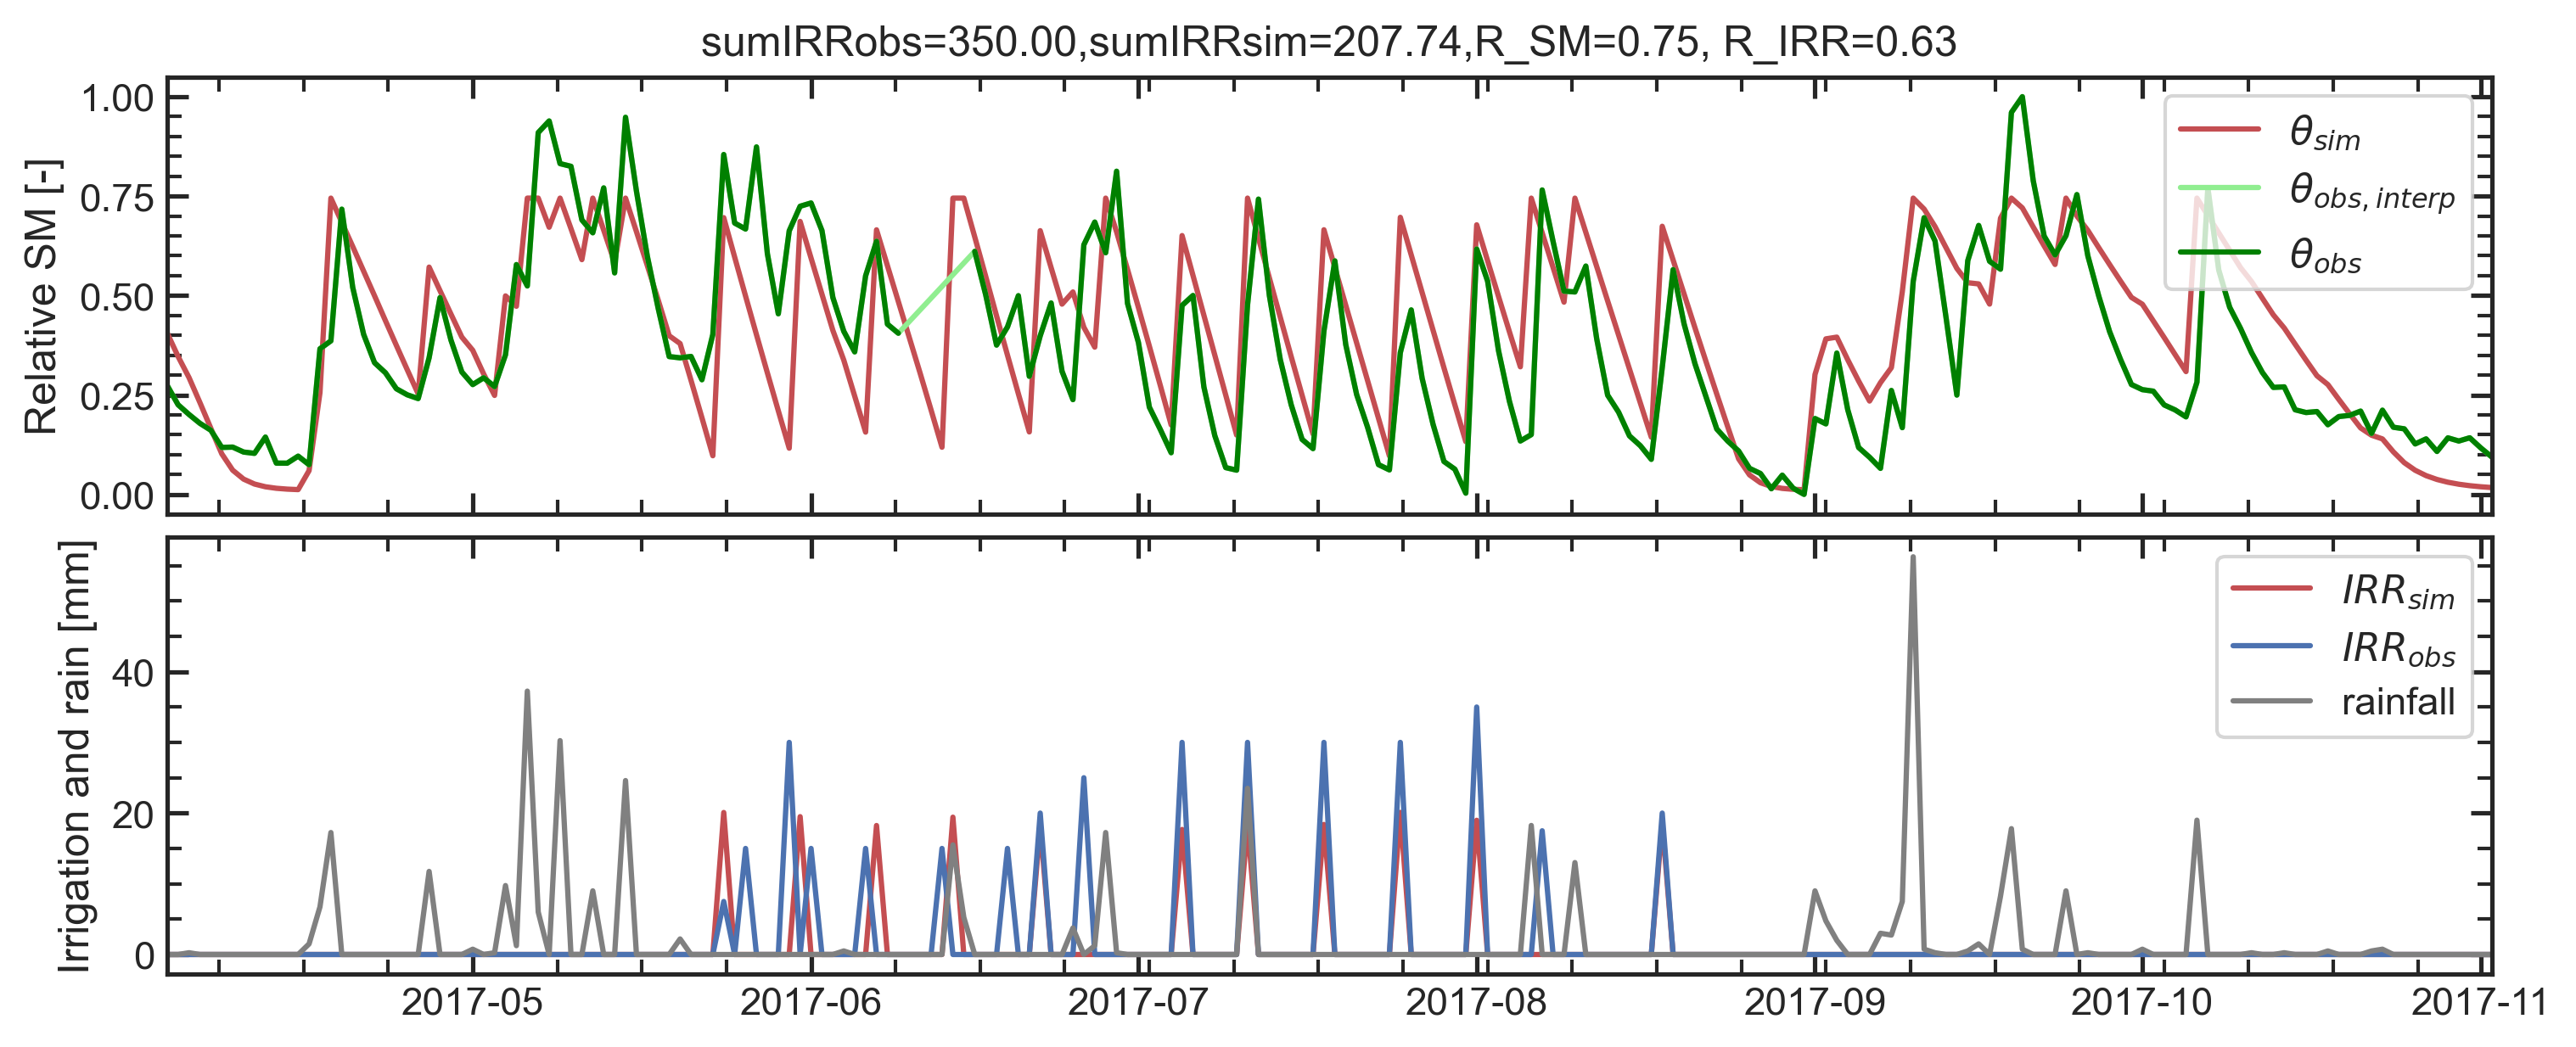

In [70]:
%%time

# User input choices
params=[]
nrun = int(input('Number of runs: '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
verbose = True if input('Verbose? [[]/(any)]=True/False')=='' else False
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norm = 1 if input('Which norm? [l1/l2] ')=='l1' else 2
irri = True if input('Do you want to calibrate irrigation as well as soil moisture? Answer yes will treat irrigation observations as a benchmark for model performance only. [[]/(any)=True/False]')=='' else False
save_plot = True if input('Save plot? [[]/(any)]')=='' else False

# -----------------------------------------------------------------------------
# Calibration run
#-----------------------------------------------------------------------------

# Initial guesses and inputs
W_0=      0.1; # [-] water content, initial [m^3/m^3]
W_max=    80;  # [mm] water content, maximum (not normalized)
S_fc=     0.46; # [-] field capacity [m^3/m^3] #********CHECK********#
S_w=      0.08; # [-] wilting point [m^3/m^3] #********CHECK********#
rho_st=   0.2; # [-] crop specific depletion fraction
Kc=       0.4; # [-] crop specific coefficient

PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc];
inputs = [D, P, IRRobs, EPOT, Wobs]

#--------------START calibration
# PAR=[W_0,W_max,S_fc,S_w,rho_st,Kc];
bounds = (
    np.array([  0.1,  0.1, .01, .01,  .1, .3]), # low
    np.array([  0.9, 150, .95, .45,  .7, .5]) # up
)
#bounds = (
#    np.array([  0.5,  50, .80, .01, .1, .3]),# low
#    np.array([  0.9, 120, .95, .45, .7, .5]) # up
#)

#-------------------------------------------
# Build an array of parameters to evaluate their distribution

for i in range(int(nrun)):
    if (optim=='global')or(optim==''):
        # options = {'c1': 0.5, 'c2': 0.9, 'w': 0.6}
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8}
        optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles), dimensions=len(PAR), options=options, bounds=bounds)
    elif optim=='local':
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8, 'k':int(0.1*n_particles), 'p':norm }
        optimizer = ps.single.LocalBestPSO(n_particles=n_particles, dimensions=len(PAR), options=options, bounds=bounds)
    else: raise NameError('Please provide an accepted option.')
    cost, PARn = optimizer.optimize(pso_calib, n_step, verbose=verbose)#, **PAR)
    params.append(PARn)
    i+=1

#------------- model run validation
#KGE,WW,WWobs,IRR = WPSO_6(convert_adim(PARn), inputs, irri)
KGE,WW,WWobs,IRR = WPSO_6(PARn, inputs, irri)
print('PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc]\n', PARn)

#-----------------------------------------------------------------------------
# Study distribution of parameters
#-----------------------------------------------------------------------------
matrix = np.array([ np.array([ params[i][j] for i in range(len(params)) ])
        for j in range(len(params[0])) ])

if (int(nrun)>9)and(input('Plot parameters distributions? [y/n]')=='y'):
    for i in range(len(matrix)):
        plt.hist(matrix[i])
        plt.show()

# ***************************************************** #
# Model performance
# ***************************************************** #
RMSE=np.nanmean((WW-WWobs)**2)**0.5; print('RMSE =', RMSE)
NS=1-np.nansum((WW-WWobs)**2)/np.nansum((WWobs-np.nanmean(WWobs))**2)
NS_radQ=1-np.nansum((np.sqrt(WW+0.00001)-np.sqrt(WWobs+0.00001))**2)/np.nansum((np.sqrt(WWobs+0.00001)-np.nanmean(np.sqrt(WWobs+0.00001)))**2)
NS_lnQ=1-np.nansum((np.log(WW+0.0001)-np.log(WWobs+0.0001))**2)/np.nansum((np.log(WWobs+0.0001)-np.nanmean(np.log(WWobs+0.0001)))**2)
NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
NS_radQ=NS_radQ.real; # print(NS_radQ)

# R coefficient score
WWmatrix = np.array( [ [WW[i], WWobs[i]] for i in range(len(WW)) if not np.isnan(WWobs[i]) ] )
R=np.corrcoef(WWmatrix,rowvar=False)[0][1]; print('R (WW vs WWobs) =', R)
IRRmatrix = np.array( [ [IRR[i], IRRobs[i]] for i in range(len(IRR)) if not np.isnan(IRRobs[i]) ] )
R_IRR=np.corrcoef(IRRmatrix,rowvar=False)[0][1]; print('R_IRR (IRR vs IRRobs)=', R_IRR)


# ***************************************************** #
# Figure
# ***************************************************** #
fig, ax = plt.subplots(2, 1,
                       constrained_layout=True,
                       figsize=(10, 4), sharex=True,
                       dpi=300,)

ax[0].set_xlim(xmin=D[0], xmax=D[len(D)-1])
ax[0].plot(D, WW, c='r', label=r'$\theta_{sim}$')
ax[0].plot(D, WWobs, c='lightgreen', label=r'$\theta_{obs,interp}$')
ax[0].plot(D, WWobs_gap, c='green', label=r'$\theta_{obs}$')
ax[0].legend(loc='upper right')
ax[0].set_title(f'sumIRRobs={np.sum(IRRobs):.2f},'+
                f'sumIRRsim={np.sum(IRR):.2f},'+
                f'R_SM={R:.2f}, R_IRR={R_IRR:.2f}')
ax[0].set_ylabel('Relative SM [-]')

ax[1].plot(D, IRR, c='r', label=r'$IRR_{sim}$')
ax[1].plot(D, IRRobs, c='b', label=r'$IRR_{obs}$')
ax[1].plot(D, P, c='gray', label=r'rainfall')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Irrigation and rain [mm]')

if save_plot==True:
    timestr = time.strftime("%y%m%d-%H%M%S")
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    if irri: 
        name = 'Irri\\'+filename+'_'+timestr+f'_{n_particles}_{n_step}_{optim_choice}_{norm}'
    else: name = filename+'_'+timestr+f'_{n_particles}_{n_step}_{optim_choice}_{norm}'
    plt.savefig('Plot\\'+name+'.png')
    plt.show()
    plt.close()
    cost_history = optimizer.cost_history
    plot_cost_history(cost_history)
    plt.savefig('Plot\\'+name+'_cost'+'.png')

## Games we play: optimizers' options handler

Ref: https://pyswarms.readthedocs.io/en/latest/examples/tutorials/options_handler.html

ONLY GLOBAL PSO WITH HANDLER IS PROVIDED AND CAN BE CHOSEN



Number of runs:  1
Number of particles:  50
Number of optimization steps:  200
Verbose? [[]/(any)]=True/False 
Global or Local PSO optimizer? [[global]/local]  
Do you want to calibrate irrigation as well as soil moisture? Answer yes will treat irrigation observations as a benchmark for model performance only. [[]/(any)=True/False] 
Save plot? [[]/(any)] 


2022-11-21 12:54:00,992 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.4, 'c2': 0.4, 'w': 0.8}
pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.269
2022-11-21 12:54:24,459 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2691595741041356, best pos: [4.47026227e-01 3.25683971e+01 7.42213859e-01 1.34400850e-02
 6.85403272e-01 3.94473486e-01]
2022-11-21 12:54:24,462 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.4, 'c2': 0.4, 'w': 0.8}
pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.299
2022-11-21 12:54:45,431 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2990025343417029, best pos: [ 0.48880621 36.12774365  0.75681091  0.17334834  0.6993899   0.48116968]


PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc]
 [4.47026227e-01 3.25683971e+01 7.42213859e-01 1.34400850e-02
 6.85403272e-01 3.94473486e-01]
RMSE = 0.16155397931343504
R (WW vs WWobs) = 0.754822588558646
R_IRR (IRR vs IRRobs)= 0.6294708579591214


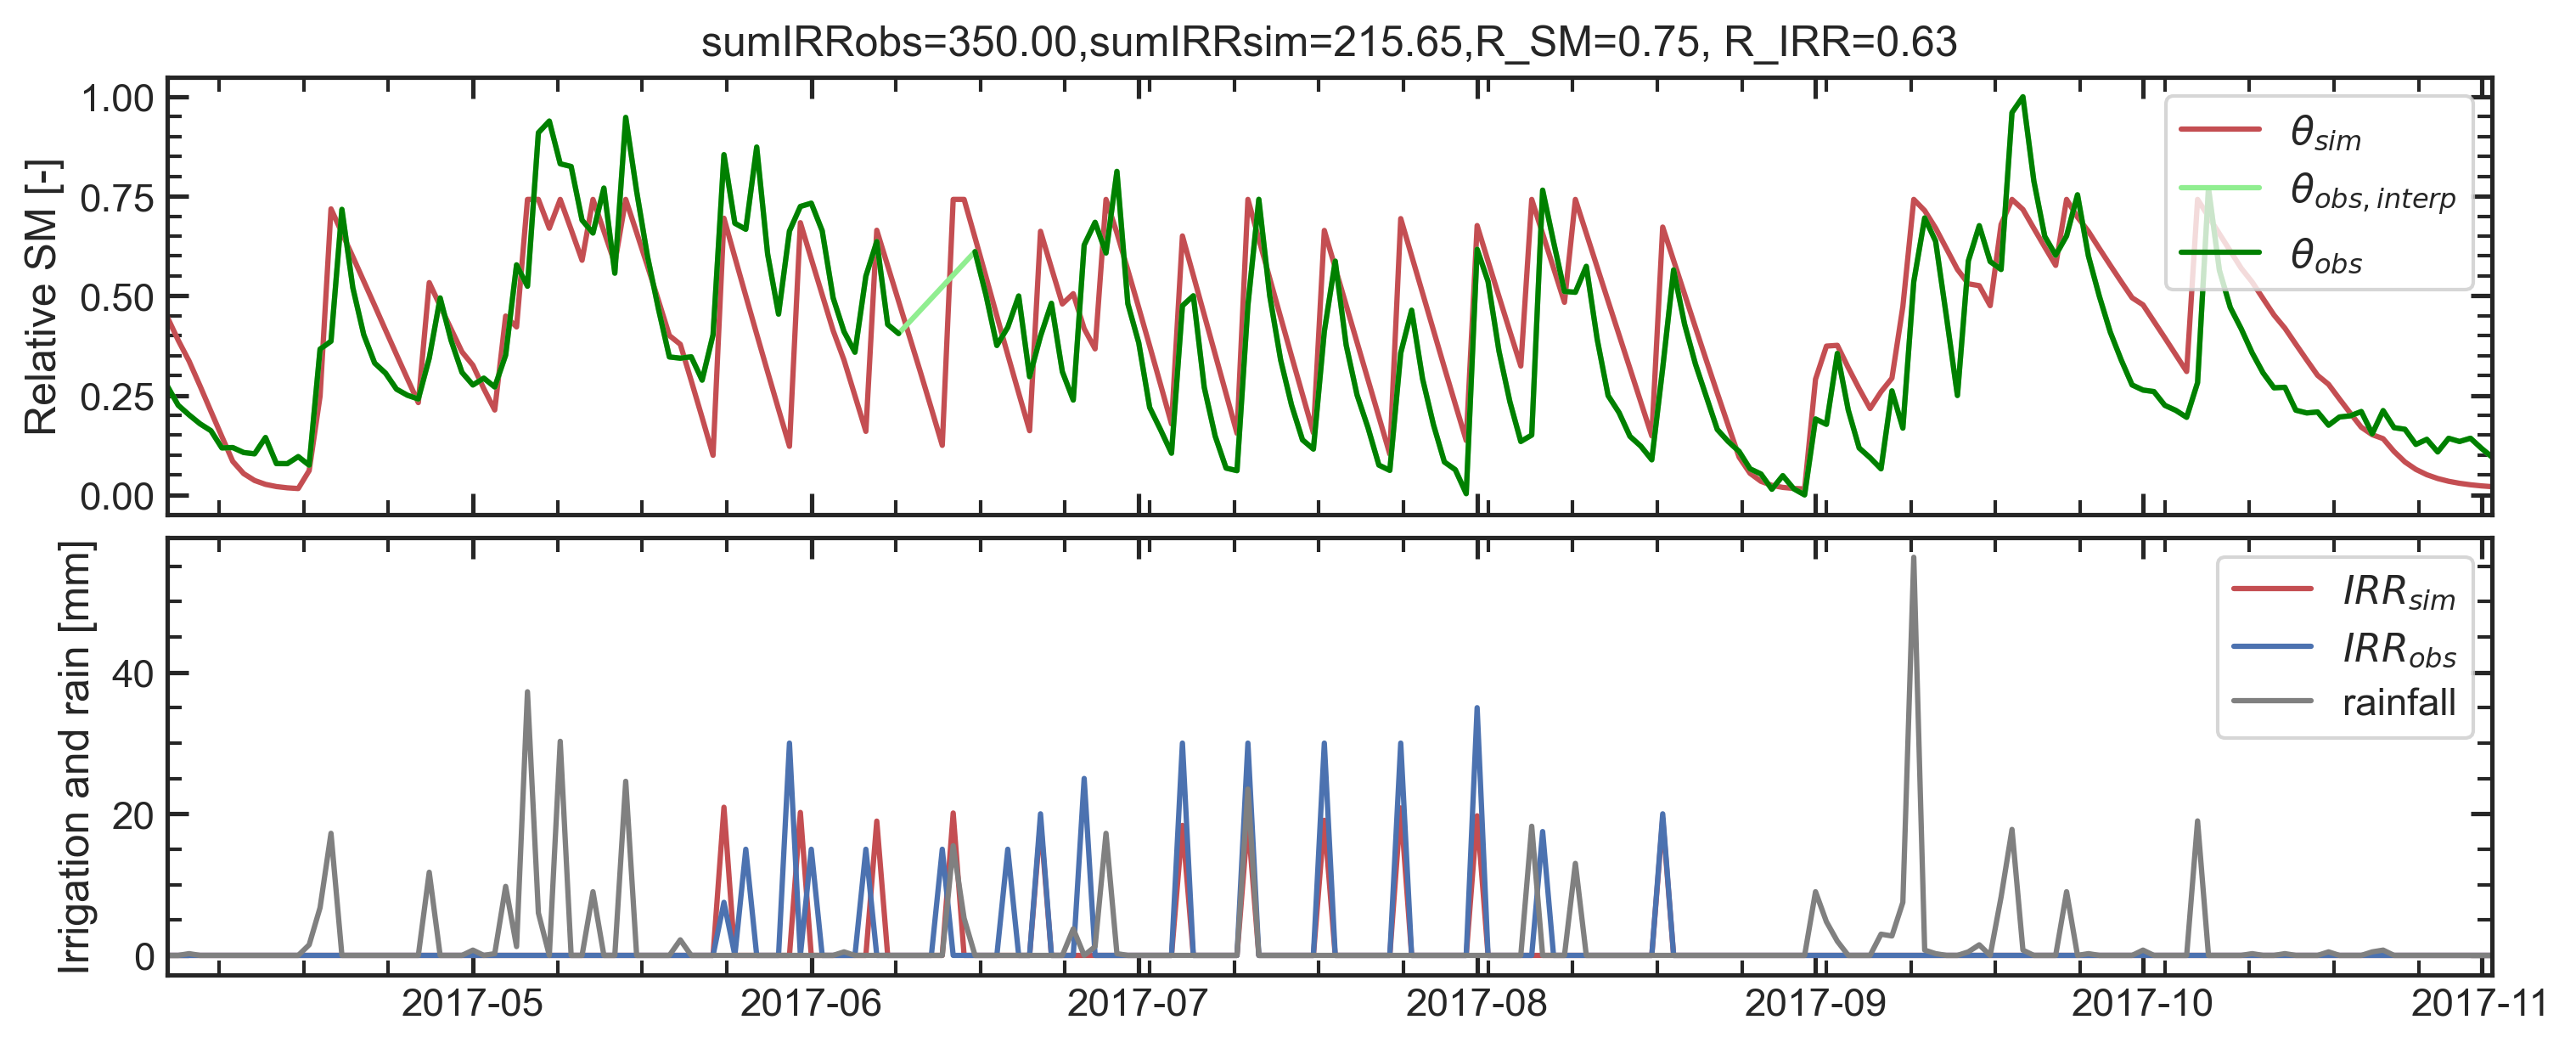

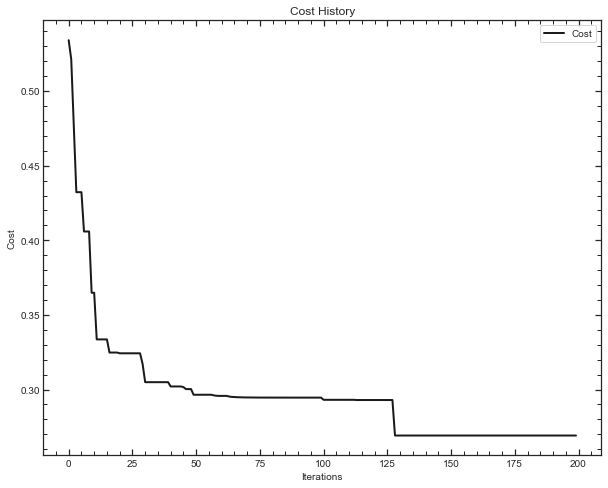

PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc]
 [ 0.48880621 36.12774365  0.75681091  0.17334834  0.6993899   0.48116968]
RMSE = 0.1715360705779355
R (WW vs WWobs) = 0.7388436646098762
R_IRR (IRR vs IRRobs)= 0.7554951720043073


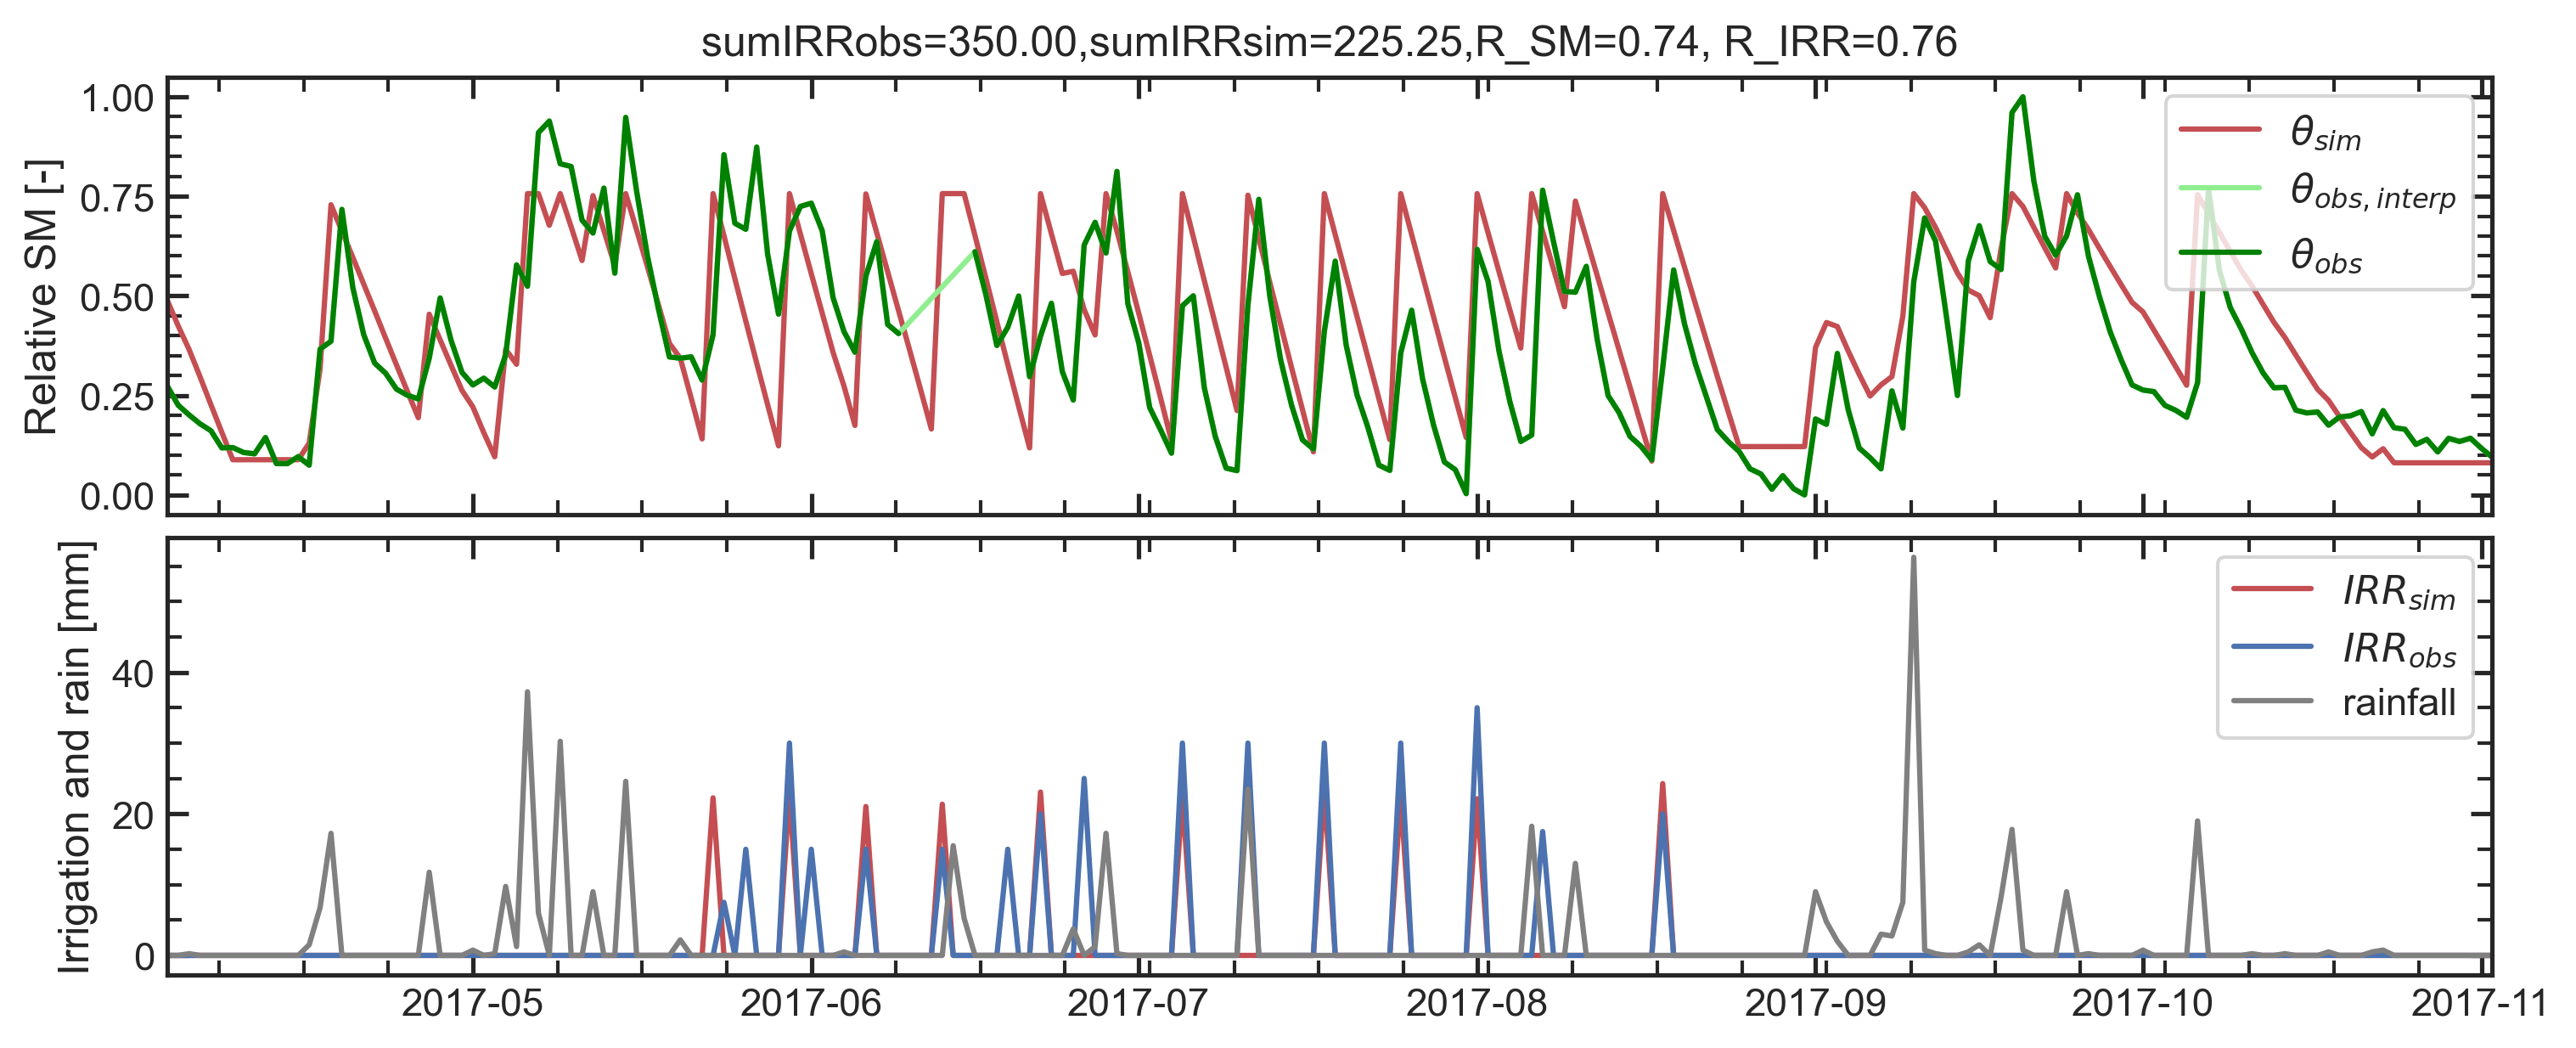

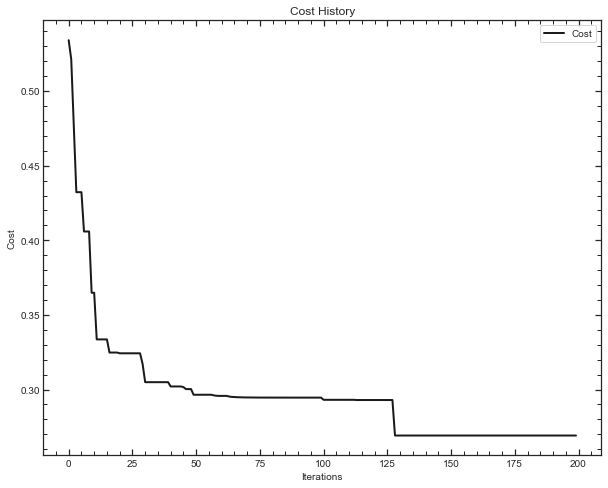

CPU times: total: 51.6 s
Wall time: 59 s


In [68]:
%%time

# User input choices
print('ONLY GLOBAL PSO WITH HANDLER IS PROVIDED AND CAN BE CHOSEN\n')

nrun = int(input('Number of runs: '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
verbose = True if input('Verbose? [[]/(any)]=True/False')=='' else False
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norm = 1 if input('Which norm? [l1/l2] ')=='l1' else 2
irri = True if input('Do you want to calibrate irrigation as well as soil moisture? Answer yes will treat irrigation observations as a benchmark for model performance only. [[]/(any)=True/False]')=='' else False
save_plot = True if input('Save plot? [[]/(any)]')=='' else False

# -----------------------------------------------------------------------------
# Calibration run
#-----------------------------------------------------------------------------

# Initial guesses and inputs
W_0=      0.1; # [-] water content, initial [m^3/m^3]
W_max=    80;  # [mm] water content, maximum (not normalized)
S_fc=     0.46; # [-] field capacity [m^3/m^3] #********CHECK********#
S_w=      0.08; # [-] wilting point [m^3/m^3] #********CHECK********#
rho_st=   0.2; # [-] crop specific depletion fraction
Kc=       0.4; # [-] crop specific coefficient

PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc];
inputs = [D, P, IRRobs, EPOT, Wobs]

#--------------START calibration
# PAR=[W_0,W_max,S_fc,S_w,rho_st,Kc];
bounds = (
    np.array([  0.1,  0.1, .01, .01,  .1, .3]), # low
    np.array([  0.9, 150, .95, .45,  .7, .5]) # up
)
#bounds = (
#    np.array([  0.5,  50, .80, .01, .1, .3]),# low
#    np.array([  0.9, 120, .95, .45, .7, .5]) # up
#)

#-------------------------------------------
# Build an array of parameters to evaluate their distribution

params=[]
params_h=[]

for i in range(int(nrun)):
    if (optim=='global')or(optim==''):
        # options = {'c1': 0.5, 'c2': 0.9, 'w': 0.6}
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8}
        optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles), dimensions=len(PAR),
                                            options=options, bounds=bounds)
        optimizer_with_handle = ps.single.GlobalBestPSO(n_particles=int(n_particles), dimensions=len(PAR),
                                                        options=options, bounds=bounds,
                                                        oh_strategy={"w":'exp_decay', 'c1':'lin_variation'})
        cost, PARs = optimizer.optimize(pso_calib, n_step, verbose=verbose)
        cost_h, PARs_h = optimizer_with_handle.optimize(pso_calib, n_step, verbose=verbose)
        
    # elif optim=='local':
    #     options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8, 'k':int(0.1*n_particles), 'p':norm }
    #     optimizer = ps.single.LocalBestPSO(n_particles=n_particles, dimensions=len(PAR), options=options, bounds=bounds)
    # else: raise NameError('Please provide an accepted option.')
    # cost, PARn = optimizer.optimize(pso_calib, n_step, verbose=verbose)#, **PAR)
    params.append(PARs)
    params.append(PARs_h)
    i+=1

for PARn in [PARs, PARs_h]:
    #------------- model run validation
    #KGE,WW,WWobs,IRR = WPSO_6(convert_adim(PARn), inputs, irri)
    KGE,WW,WWobs,IRR = WPSO_6(PARn, inputs, irri)
    
    print('PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc]\n', PARn)
    
    #-----------------------------------------------------------------------------
    # Study distribution of parameters
    #-----------------------------------------------------------------------------
    matrix = np.array([ np.array([ params[i][j] for i in range(len(params)) ])
            for j in range(len(params[0])) ])
    
    if (int(nrun)>9)and(input('Plot parameters distributions? [y/n]')=='y'):
        for i in range(len(matrix)):
            plt.hist(matrix[i])
            plt.show()
    
    # ***************************************************** #
    # Model performance
    # ***************************************************** #
    RMSE=np.nanmean((WW-WWobs)**2)**0.5; print('RMSE =', RMSE)
    NS=1-np.nansum((WW-WWobs)**2)/np.nansum((WWobs-np.nanmean(WWobs))**2)
    NS_radQ=1-np.nansum((np.sqrt(WW+0.00001)-np.sqrt(WWobs+0.00001))**2)/np.nansum((np.sqrt(WWobs+0.00001)-np.nanmean(np.sqrt(WWobs+0.00001)))**2)
    NS_lnQ=1-np.nansum((np.log(WW+0.0001)-np.log(WWobs+0.0001))**2)/np.nansum((np.log(WWobs+0.0001)-np.nanmean(np.log(WWobs+0.0001)))**2)
    NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
    NS_radQ=NS_radQ.real; # print(NS_radQ)
    
    # R coefficient score
    WWmatrix = np.array( [ [WW[i], WWobs[i]] for i in range(len(WW)) if not np.isnan(WWobs[i]) ] )
    R=np.corrcoef(WWmatrix,rowvar=False)[0][1]; print('R (WW vs WWobs) =', R)
    IRRmatrix = np.array( [ [IRR[i], IRRobs[i]] for i in range(len(IRR)) if not np.isnan(IRRobs[i]) ] )
    R_IRR=np.corrcoef(IRRmatrix,rowvar=False)[0][1]; print('R_IRR (IRR vs IRRobs)=', R_IRR)
    
    
    # ***************************************************** #
    # Figure
    # ***************************************************** #
    fig, ax = plt.subplots(2, 1,
                           constrained_layout=True,
                           figsize=(10, 4), sharex=True,
                           dpi=300,)
    
    ax[0].set_xlim(xmin=D[0], xmax=D[len(D)-1])
    ax[0].plot(D, WW, c='r', label=r'$\theta_{sim}$')
    ax[0].plot(D, WWobs, c='lightgreen', label=r'$\theta_{obs,interp}$')
    ax[0].plot(D, WWobs_gap, c='green', label=r'$\theta_{obs}$')
    ax[0].legend(loc='upper right')
    ax[0].set_title(f'sumIRRobs={np.sum(IRRobs):.2f},'+
                    f'sumIRRsim={np.sum(IRR):.2f},'+
                    f'R_SM={R:.2f}, R_IRR={R_IRR:.2f}')
    ax[0].set_ylabel('Relative SM [-]')
    
    ax[1].plot(D, IRR, c='r', label=r'$IRR_{sim}$')
    ax[1].plot(D, IRRobs, c='b', label=r'$IRR_{obs}$')
    ax[1].plot(D, P, c='gray', label=r'rainfall')
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('Irrigation and rain [mm]')
    
    if save_plot==True:
        timestr = time.strftime("%y%m%d-%H%M%S")
        optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
        if irri: 
            name = 'Irri\\'+filename+'_'+timestr+f'_{n_particles}_{n_step}_{optim_choice}_{norm}'
        else: name = filename+'_'+timestr+f'_{n_particles}_{n_step}_{optim_choice}_{norm}'
        plt.savefig('Plot\\'+name+'.png')
        plt.show()
        plt.close()
        cost_history = optimizer.cost_history
        plot_cost_history(cost_history)
        plt.savefig('Plot\\'+name+'_cost'+'.png')
        plt.show()

# Comparison with satellite-derived SM

**GOAL**: scatterplot between retrieved SM from model calibrated with obs and satellite-derived SM

**Workflow**
- get retrieved SM vector (any options for the run will do)
- get SM from sat
- intersecate dates
- plot

Please provide the satellite product you want to use.[Options: CCI_active, SMAP, THEIA, RT1] CCI_active
Save plots (timeseries+scatter)? [[]/any] 


Be aware that SM data from satellite are NOT interpolated here (comparison run).
R (WW vs WWobs) = 0.3152333709866237 
R^2 (WW vs WWobs) = 0.09937207818359031
RMSE = 0.41455751288861953


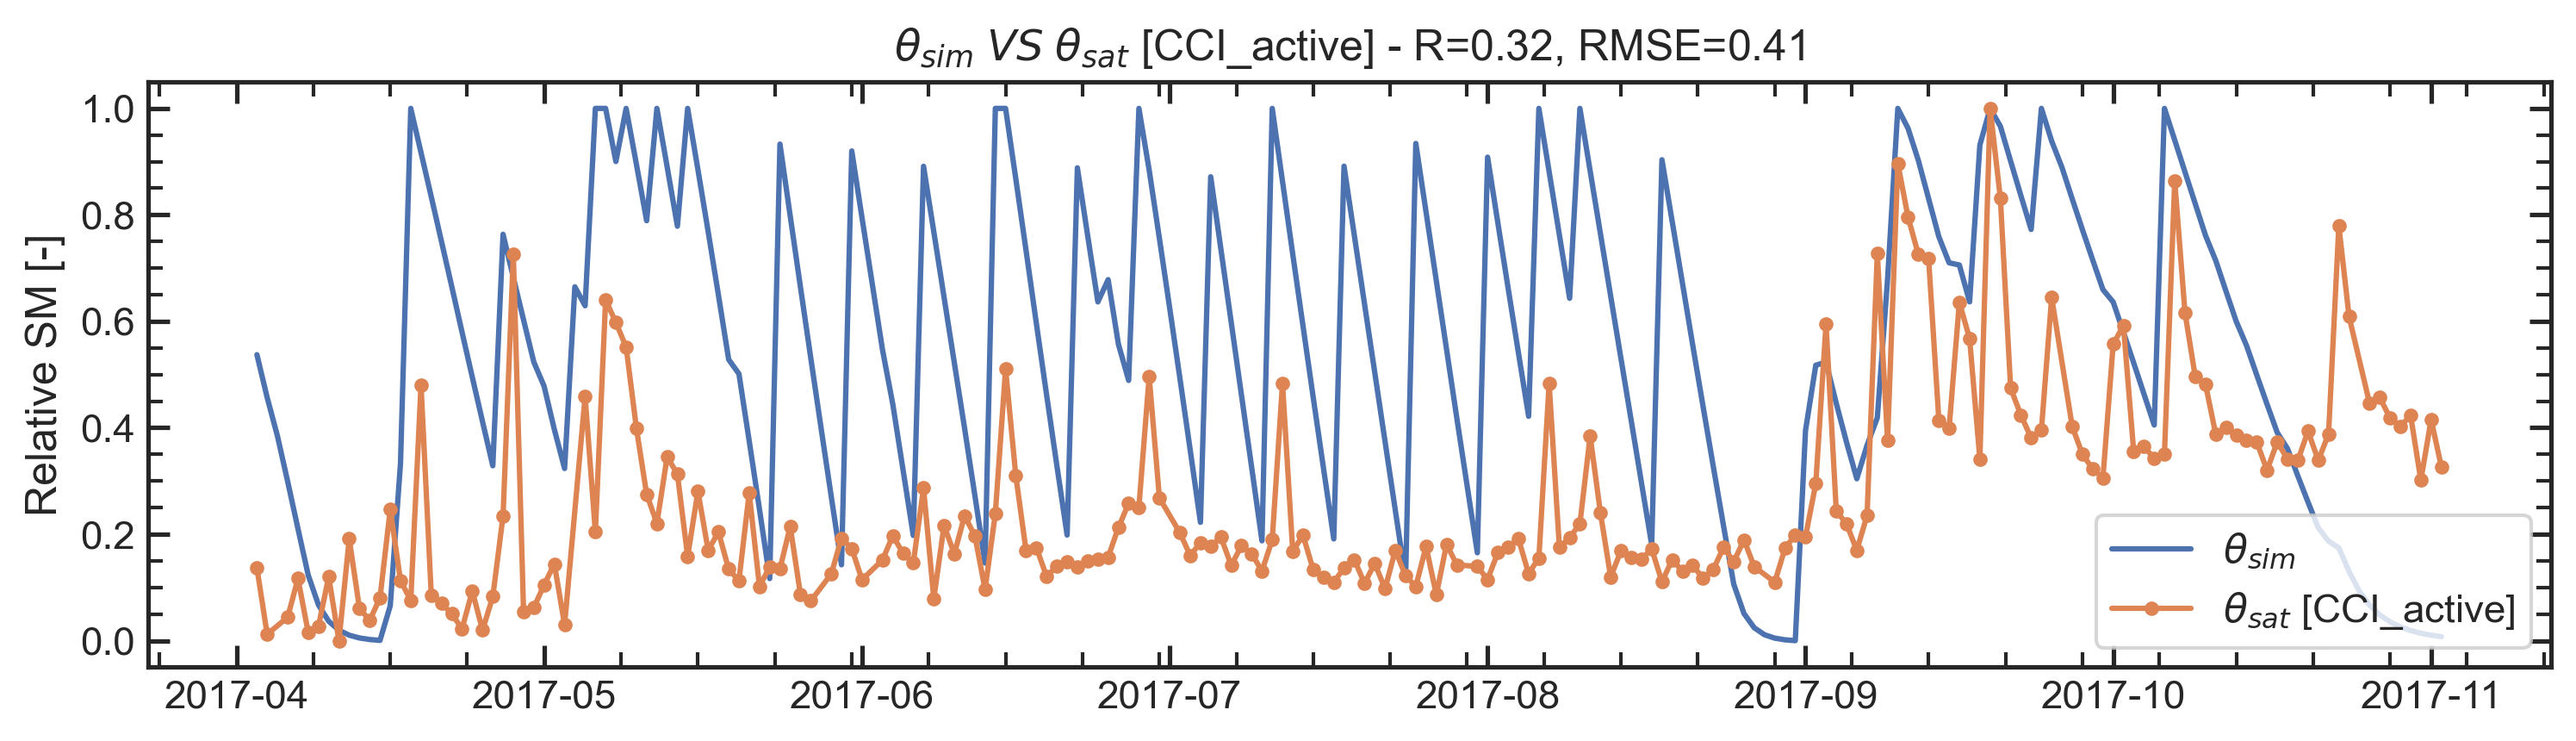

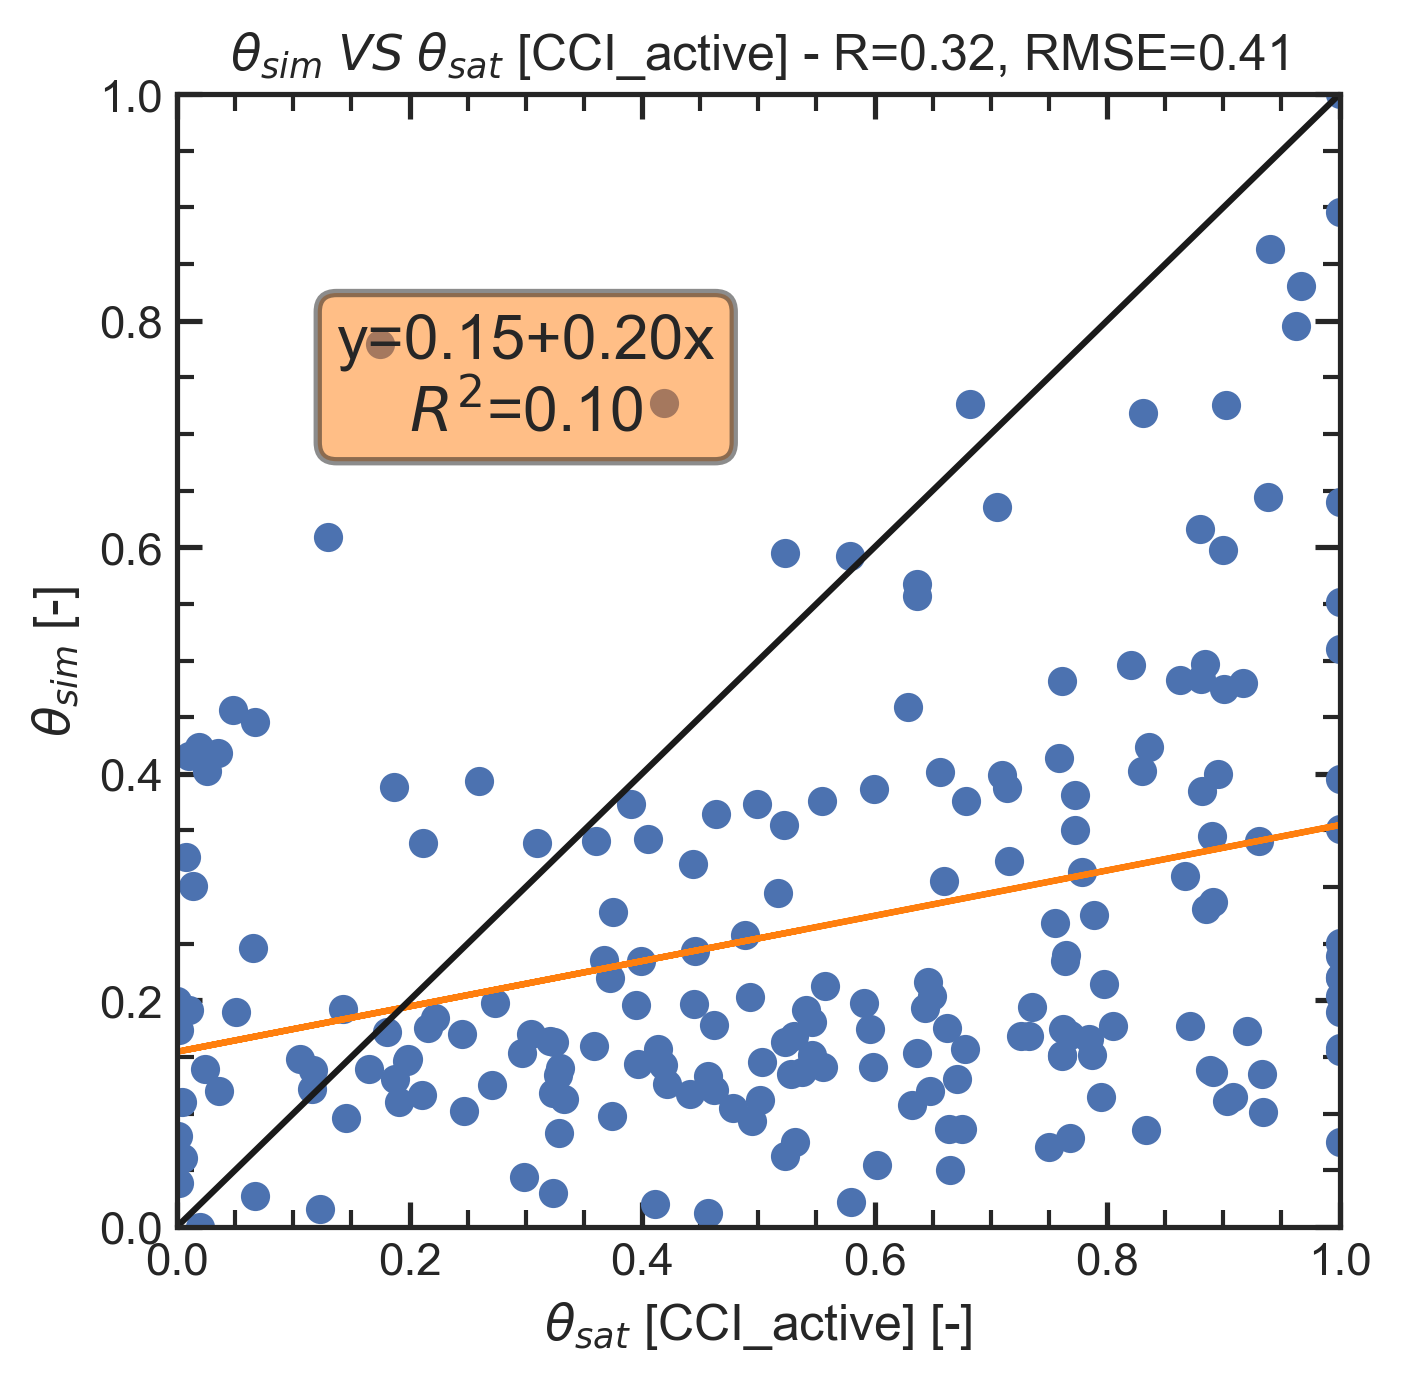

In [23]:
# Data reading

sat = input('Please provide the satellite product you want to use.'
            +'[Options: CCI_active, SMAP, THEIA, RT1]')
save = True if input('Save plots (timeseries+scatter)? [[]/any]')=='' else False
print('Be aware that SM data from satellite are NOT interpolated here (comparison run).')

# Data reading

# ************************************************** #
# Variables definition
# ************************************************** #

namesite = 'ITALY_BUDRIO'
siteID = '5'
namefig = namesite+'_'+siteID

# ************************************************** #
# Data reading
# ************************************************** #

# Field data from TEST_SITE
df = xr.open_dataset(f'TEST_SITE\TEST_SITE_{namesite}.nc', engine='netcdf4').to_dataframe(); df

# Satellite data from Golden tables
golden = pd.read_csv(f'..\Data\Golden_GEE.csv', delimiter = "\t")

# Budrio field data from Platinum tables
platinum = pd.ExcelFile('..\Data\Platinum_Budrio.xlsx', engine='openpyxl')
platinum = platinum.parse('2017_1h')
platinum['Ora_1'] = pd.to_datetime(platinum['Ora'].astype('str')).apply(lambda x: x.time())
platinum['Data_1'] = pd.to_datetime(platinum['Data'].astype('str')).apply(lambda x: x.date())
platinum['Date'] = platinum.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
platinum = platinum.drop(['ID', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)

# NOTE: this dataset has to be DAILY!!
# Methods to resample timeseries-like databases: groupby, resample
# Dailiness is computed directly when extracting a given input

# Dates
D_0 = df.Time_days
D_1 = platinum['Data']
set1 = {x for x in D_0}
set2 = {x for x in D_1}
D = np.sort(np.array([*set1.intersection(set2)]))

# Other inputs
P = platinum.resample('1D',on='Date').sum()['Pioggia[mm]'].values
EPOT = df.set_index('Time_days').loc[D][f'PET_{siteID}'].values # evapotranspiration (measured)
IRRobs = platinum.resample('1D',on='Date').sum()['Irrigazione[mm]'].values

#-----------------------------------------------------------------------------

WW = np.loadtxt('sim-vs-sat\\WW_simulated.txt')
WWnorm = norm(WW)

# Satellite-derived SM is already normalized
WWsat = df.set_index('Time_days').loc[D][f'SSM_{sat}_{siteID}'].values
WWsat_interp = df.set_index('Time_days').loc[D][f'SSM_{sat}_{siteID}'].interpolate(method='linear',limit_direction='both').values
WWsat = (WWsat-np.min(WWsat_interp))/(np.max(WWsat_interp)-np.min(WWsat_interp))

WWmatrix_sat = np.array( [ [WWnorm[i], WWsat[i]] for i in range(len(WW)) if not np.isnan(WWsat[i]) ] )

# Correlation metrics
R=np.corrcoef(WWmatrix_sat,rowvar=False)[0][1]; print('R (WW vs WWobs) =', R, '\nR^2 (WW vs WWobs) =', R**2)
RMSE=np.nanmean((WWnorm-WWsat)**2)**0.5; print('RMSE =', RMSE)

#-----------------------------------------------------------------------------
# Timeseries

D_sat = np.array( [ D[i] for i in range(len(D)) if not np.isnan(WWsat[i]) ] )

plt.figure(figsize=(12,3), dpi=300)
plt.plot(D, WWnorm, label=r'$\theta_{sim}$')
plt.plot(D_sat, WWsat[~np.isnan(WWsat)], marker='o', linestyle='-', 
         label=(r'$\theta_{sat}$'+f' [{sat}]'), markersize=3)
plt.ylabel('Relative SM [-]')
plt.title(r'$\theta_{sim}\;VS\;\theta_{sat}$' + f' [{sat}] - R={R:.2f}, RMSE={RMSE:.2f}')
plt.legend(loc='lower right')
if save: plt.savefig(f'sim-vs-sat\\sim-vs-sat_{sat}_timeseries.png')

#-----------------------------------------------------------------------------
# Scatterplot

def linear(x,a,b):
    return a+b*x

# Data from satellite and retrieved are to compare where they are both not nan
# so exploit list comprehension for slicing WWmatrix_sat
WWclean = [e[0] for e in WWmatrix_sat]

plt.figure(figsize=(5,5), dpi=300)
plt.scatter(WWclean, WWsat[~np.isnan(WWsat)])
popt, pcov = curve_fit(linear, WWclean, WWsat[~np.isnan(WWsat)])
plt.plot(WWnorm, linear(np.array(WWnorm),*popt), color='tab:orange')

x=np.linspace(0,1,100); y=x; plt.plot(x,y,color='k')
plt.title(r'$\theta_{sim}\;VS\;\theta_{sat}$' + f' [{sat}] - R={R:.2f}, RMSE={RMSE:.2f}')
plt.ylabel(r'$\theta_{sim}$ [-]'); plt.xlabel(r'$\theta_{sat}$'+f' [{sat}] [-]')
plt.xlim(0,1); plt.ylim(0,1)
t = plt.text(0.3, 0.75,
             f'y={popt[0]:.2f}+{popt[1]:.2f}x\n'+
             r'$R^2$'+f'={R**2:.2f}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))
if save: plt.savefig(f'sim-vs-sat\\sim-vs-sat_{sat}_scatter.png')